In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


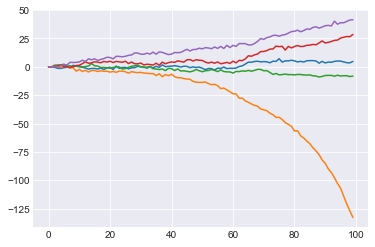

In [2]:
T, n = 100, 5
y = np.zeros((T, n))
beta0 = .45 + np.random.rand(2, n)*.1

for i in range(2, T):
    y[i] = beta0[0] * y[i-1] + beta0[1] * y[i-2] + np.random.randn(n)

plt.plot(y);

In [3]:
beta0

array([[0.50591782, 0.54371988, 0.47504312, 0.47411339, 0.48401577],
       [0.53706959, 0.52785639, 0.53034361, 0.54762805, 0.5452366 ]])

In [15]:
import theano.tensor as tt
from theano import scan
from pymc3.distributions.distribution import Continuous
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat


class AR2d(Continuous):
    R"""
    Autoregressive process with p lags.
    .. math::
       x_t = \rho_0 + \rho_1 x_{t-1} + \ldots + \rho_p x_{t-p} + \epsilon_t,
       \epsilon_t \sim N(0,\sigma^2)
    The innovation can be parameterized either in terms of precision
    or standard deviation. The link between the two parametrizations is
    given by
    .. math::
       \tau = \dfrac{1}{\sigma^2}
    Parameters
    ----------
    rho : tensor
        Vector of autoregressive coefficients.
    sd : float
        Standard deviation of innovation (sd > 0). (only required if tau is not specified)
    tau : float
        Precision of innovation (tau > 0). (only required if sd is not specified)
    constant: bool (optional, default = False)
        Whether to include a constant.
    init : distribution
        distribution for initial values (Defaults to Flat())
    """

    def __init__(self, rho, sd=None, tau=None,
                 constant=False, init=Flat.dist(),
                 *args, **kwargs):

        super(AR2d, self).__init__(*args, **kwargs)
        tau, sd = get_tau_sd(tau=tau, sd=sd)
        self.sd = tt.as_tensor_variable(sd)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = tt.as_tensor_variable(0.)

        rho = tt.as_tensor_variable(rho, ndim=2)
        if constant:
            self.p = rho.shape[0] - 1
        else:
            self.p = rho.shape[0]

        self.constant = constant
        self.rho = rho
        self.init = init

    def logp(self, value):
        if self.constant:
            results, _ = scan(lambda l_, obs, p, rho: rho[l_ - 1] * obs[p - l_:-l_],
                              outputs_info=None, sequences=[tt.arange(1, self.p + 1)],
                              non_sequences=[value, self.p, self.rho[1:]])
            x = tt.sum(results, axis=0)
            eps = value[self.p:] - self.rho[0] - x
        else:
            results, _ = scan(lambda l_, obs, p, rho: rho[l_ - 1] * obs[p - l_:-l_],
                              outputs_info=None, sequences=[tt.arange(1, self.p + 1)],
                              non_sequences=[value, self.p, self.rho])
            x = tt.sum(results, axis=0)
            eps = value[self.p:] - x

        innov_like = Normal.dist(mu=0.0, tau=self.tau).logp(eps)
        init_like = self.init.logp(value[:self.p])

        return tt.sum(innov_like) + tt.sum(init_like)

In [16]:
with pm.Model() as ar1:
    beta = pm.Uniform('beta', 0., 1., shape=(2, n))
    data = AR2d('y', beta, sd=1.0, observed=y)
    trace = pm.sample(1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:49<00:00, 19.64draws/s]


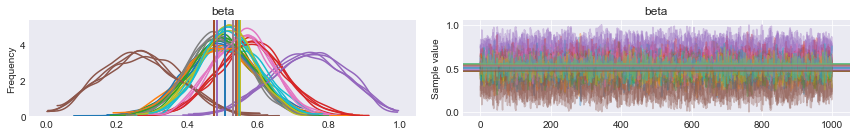

In [17]:
pm.traceplot(trace, lines=dict(beta=beta0));

In [18]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0_0,0.490366,0.097217,0.001566,0.295425,0.673884,3035.058925,0.999753
beta__0_1,0.496059,0.089724,0.001660,0.321900,0.676748,2816.582266,1.000058
beta__0_2,0.739322,0.107043,0.002524,0.536063,0.938606,2128.879925,1.000362
beta__0_3,0.552727,0.082926,0.001524,0.389777,0.710303,3015.915270,1.000172
beta__0_4,0.507530,0.082601,0.001542,0.349616,0.671296,2798.386365,0.999940
beta__1_0,0.492394,0.098544,0.001621,0.304277,0.689914,3001.140289,0.999747
beta__1_1,0.578126,0.094113,0.001739,0.389966,0.761358,2812.140856,1.000067
beta__1_2,0.268450,0.109533,0.002565,0.071716,0.487123,2120.278918,1.000269
beta__1_3,0.487842,0.085698,0.001552,0.327042,0.659666,3031.406682,1.000181
beta__1_4,0.521352,0.084286,0.001574,0.358104,0.684779,2789.344700,0.999944


In [7]:
with pm.Model() as ar2:
    beta = pm.Uniform('beta', 0., 1., shape=(2, n))
    for i in range(n):
        pm.AR('y_%d'%i, beta[:, i], sd=1.0, observed=y[:, i])
    trace2 = pm.sample(1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:09<00:00, 23.70draws/s]


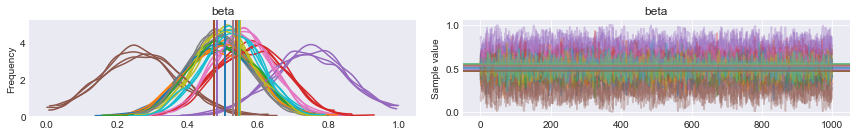

In [8]:
pm.traceplot(trace2, lines=dict(beta=beta0));

In [10]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0_0,0.490114,0.097210,0.001685,0.307623,0.683230,2875.943519,0.999588
beta__0_1,0.496478,0.092661,0.001806,0.321466,0.674842,2746.785223,1.000055
beta__0_2,0.742043,0.108488,0.002499,0.538053,0.959203,1947.556589,1.000614
beta__0_3,0.554577,0.083923,0.001693,0.401763,0.729273,2563.164071,1.000088
beta__0_4,0.503827,0.082815,0.001583,0.338595,0.659360,2913.061505,1.000673
beta__1_0,0.491816,0.098479,0.001737,0.292956,0.675417,2876.655748,0.999750
beta__1_1,0.577624,0.097065,0.001893,0.392719,0.762229,2752.114784,1.000058
beta__1_2,0.265701,0.110036,0.002600,0.060965,0.486493,1968.561367,1.000956
beta__1_3,0.486151,0.086242,0.001748,0.309239,0.645662,2563.064959,1.000150
beta__1_4,0.525134,0.084510,0.001618,0.362553,0.689907,2907.226096,1.000630
